Regla delta generalizada y algoritmos con supermemoria
===

Preparación
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

Descripción del problema
---

En el algoritmo de gradiente descendente, el proceso de optimización usa la siguiente ecuación recursiva:

$$ \mathbf{w}_k = \mathbf{w}_{k-1} - \mu \frac{\partial}{\partial \mathbf{w}} f(\mathbf{w}_{k-1})$$

Como caso de aplicación se desea ajustar el modelo de regresión lineal 

$$y_i = w_0 + w_1 * x_i$$

al siguiente conjunto de datos:

In [2]:
x_sample = np.array(
    [
        0.1087,
        0.2698,
        0.3765,
        0.2146,
        0.9155,
        0.0246,
        0.0221,
        0.8632,
        0.6460,
        0.2092,
        0.8567,
        0.1591,
        0.9647,
        0.6231,
        0.7460,
        0.3654,
        0.3065,
        0.6886,
        0.4966,
        0.2008,
        0.2618,
        0.7607,
        0.1563,
        0.4424,
        0.7731,
    ]
)

y_sample = np.array(
    [
        0.9519,
        1.1237,
        1.2360,
        1.0526,
        2.0743,
        0.7906,
        0.7603,
        2.0533,
        1.6887,
        1.0563,
        2.0991,
        0.8953,
        2.1917,
        1.6266,
        1.8508,
        1.2828,
        1.2283,
        1.8722,
        1.4657,
        1.0418,
        1.1097,
        1.7826,
        0.9711,
        1.4267,
        1.8248,
    ]
)

Para ello, se usa como función de pérdida la sumatoria del error cuadrático (SSE) definda como:

$$\text{SSE}(w_0, w_1) = \sum_i (d_i - w_0 - w_1 x_i)^2 $$

In [3]:
def sse(w0, w1):
    y_forecasts = [w0 + w1 * x_value for x_value in x_sample]
    errors = [y_true - y_forecast for y_true, y_forecast in zip(y_sample, y_forecasts)]
    squared_errors = [error ** 2 for error in errors]
    return sum(squared_errors)

Como ya se explicó, la función SSE() es una cuadrática con forma de tazón y un único punto de mínima que corresponde al valor óptimo de los parámetros $w_0$ y $w_1$. La gráfica de la cuadrática es presentada a continuación.

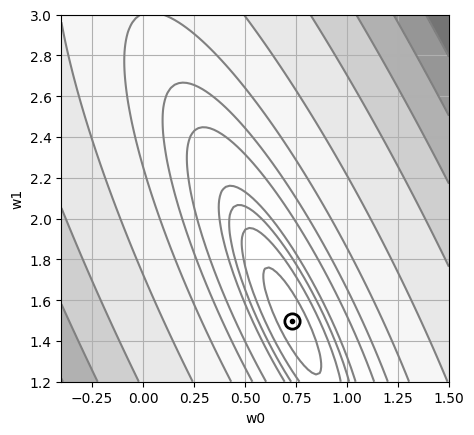

In [4]:
def plot_contour():

    W0 = np.linspace(-0.4, 1.5, 100)
    W1 = np.linspace(1.2, 3.0, 100)
    W0, W1 = np.meshgrid(W0, W1)
    F = sse(W0, W1)

    levels = [0, 0.2, 0.5, 0.75, 1, 2, 3, 5, 10, 20, 30, 40, 50, 60]

    _, ax = plt.subplots(figsize=(5, 5))
    ax.set_aspect("equal", "box")
    ax.contourf(W0, W1, F, cmap=cm.Greys, levels=levels, alpha=0.6)
    ax.contour(W0, W1, F, colors="gray", levels=levels)
    plt.plot(
        [0.731],
        [1.498],
        "o",
        color="black",
        fillstyle="none",
        markersize=11,
        markeredgewidth=2,
    )
    plt.plot([0.731], [1.498], ".", color="black")
    ax.set_xlabel("w0")
    ax.set_ylabel("w1")
    ax.grid()


plot_contour()

Tal como ya se habia explicado, la técnica del gradiente descendente se basa en un proceso iterativo que usa la siguiente ecuación para refinar la aproximación al valor óptimo de los parámetros:

$$ \mathbf{w}_k = \mathbf{w}_{k-1} - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1})$$

con:

$$\frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}) = 
\left[
  \begin{array}{c}
  -2 \sum_i  e_i
  \\
  -2 \sum_i  e_i x_i
  \end{array}
\right]
$$

Estos cómputos son implementados a continuación.

In [5]:
def gradient(w0, w1):

    y_forecasts = [w0 + w1 * x_value for x_value in x_sample]

    errors = [y_true - y_forecast for y_true, y_forecast in zip(y_sample, y_forecasts)]

    gradient_w0 = -2 * sum(errors)
    gradient_w1 = -2 * sum(
        [error * x_value for error, x_value in zip(errors, x_sample)]
    )

    return gradient_w0, gradient_w1

In [6]:
def improve(w0, w1, mu):

    gradient_w0, gradient_w1 = gradient(w0, w1)

    w0 = w0 - mu * gradient_w0
    w1 = w1 - mu * gradient_w1

    return w0, w1

El proceso de optimización se realiza de un punto inicial arbitrario. A continuación se presenta el valor encontrado y la traza de puntos que recorre el algoritmo hasta llegar al óptimo.

 w0 = 0.6786
 w1 = 1.6341
SSE = 0.0924


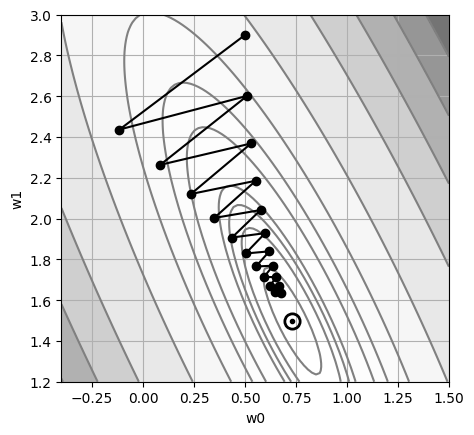

In [7]:
# Punto de inicio
w0 = 0.5
w1 = 2.9

history_gd = {
    "w0": [w0],
    "w1": [w1],
    "sse": [sse(w0, w1)],
}

mu = 0.03

for epoch in range(20):

    w0, w1 = improve(w0, w1, mu)

    history_gd["w0"].append(w0)
    history_gd["w1"].append(w1)
    history_gd["sse"].append(sse(w0, w1))

print(" w0 = {:6.4f}\n w1 = {:6.4f}\nSSE = {:6.4f}".format(w0, w1, sse(w0, w1)))

plot_contour()
plt.plot(history_gd["w0"], history_gd["w1"], marker="o", color="black")
plt.show()

Note que el algoritmo realiza una caminata en zigzag (va y se devuelve) intentando llegar al óptimo. Este comportamiento es indeseable y se desea evitar el zigzag ya que se desperdician iteraciones para llegar al óptimo.

Momentum
---

Para evitar el zigzag, se desea usar la dirección del gradiente actual ponderada por la dirección previa. Esta metodología se conoce como regla delta (en la jerga de redes neuronales artificiales) o gradiente con memoria (en investigación de operaciones). 

Específicamente, el proceso de optimización se basa en la siguiente ecuación recursiva (ya estudiada):

$$ 
\mathbf{w}_k = \mathbf{w}_{k-1} - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1})
$$


la cual que puede ser reescrita como:

$$\mathbf{w}_k = \mathbf{w}_{k-1} + \Delta \mathbf{w}_{k-1}$$

con:

$$\Delta \mathbf{w}_{k-1} = - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1})$$

La dirección tomada en la iteración anterior será $\Delta \mathbf{w}_{k-2}$. Ahora, solo es necesario agregar este término a la ecuación anterior, ponderado por un parámetro $\beta$ conocido comúnmente como *momentum*:

$$\Delta \mathbf{w}_{k-1} = - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1}) + \beta \Delta \mathbf{w}_{k-2}$$

La implementación es la siguiente:

In [8]:
def improve(w0, w1, mu, beta):

    # Corrección en la iteración anterior.
    global previous_delta_w0
    global previous_delta_w1

    # Computó del gradiente para los parámetros actuales
    gradient_w0, gradient_w1 = gradient(w0, w1)

    # Corrección de los parámetros
    delta_w0 = -mu * gradient_w0 + beta * previous_delta_w0
    delta_w1 = -mu * gradient_w1 + beta * previous_delta_w1

    # Almacenamiento de la corrección para la siguiente iteración
    previous_delta_w0 = delta_w0
    previous_delta_w1 = delta_w1

    w0 = w0 + delta_w0
    w1 = w1 + delta_w1

    return w0, w1

El proceso de iterativo de optimización es el siguiente:

 w0 = 0.7053
 w1 = 1.5258
SSE = 0.0571


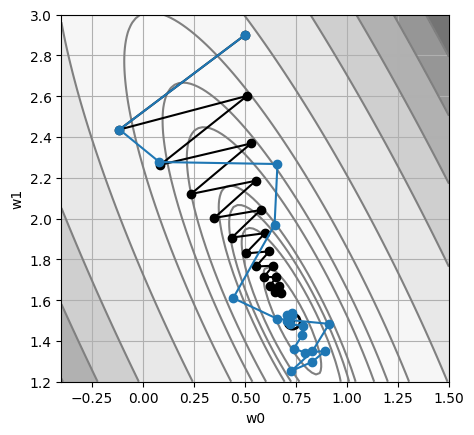

In [9]:
# Punto de inicio
w0 = 0.5
w1 = 2.9

history_dr = {
    "w0": [w0],
    "w1": [w1],
    "sse": [sse(w0, w1)],
}

previous_delta_w0 = 0
previous_delta_w1 = 0

for epoch in range(20):

    w0, w1 = improve(w0, w1, mu=0.03, beta=0.7)

    history_dr["w0"].append(w0)
    history_dr["w1"].append(w1)
    history_dr["sse"].append(sse(w0, w1))

print(" w0 = {:6.4f}\n w1 = {:6.4f}\nSSE = {:6.4f}".format(w0, w1, sse(w0, w1)))

plot_contour()
plt.plot(history_gd["w0"], history_gd["w1"], marker="o", color="black")
plt.plot(history_dr["w0"], history_dr["w1"], marker="o", color="tab:blue")
plt.show()

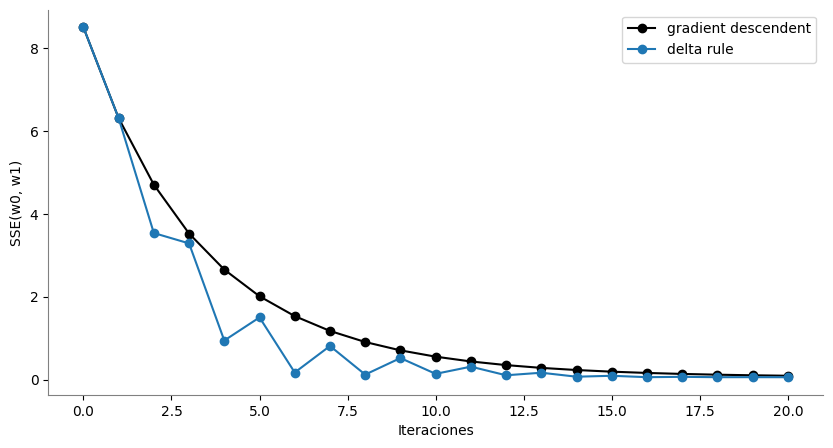

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(history_gd["sse"], "o-k", label="gradient descendent")
plt.plot(history_dr["sse"], "o-", color="tab:blue", label="delta rule")
plt.xlabel("Iteraciones")
plt.ylabel("SSE(w0, w1)")
plt.gca().spines["left"].set_color("gray")
plt.gca().spines["bottom"].set_color("gray")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend()
plt.show()

Algoritmos con supermemoria
---

Son algoritmos de estructura similar a la regla delta, pero consideran $P$ valores de $\Delta \mathbf{w}$ hacia atrás.

$$\Delta \mathbf{w}_{k-1} = - \mu \frac{\partial}{\partial \mathbf{w}} \text{SSE}(\mathbf{w}_{k-1}) + \sum_{p=0}^P \beta_p \Delta \mathbf{w}_{k-2-p}$$